In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

In [24]:
def compile_metal_data(df, year, geography, variables_to_keep):
    df = df.copy()

    # Handle REF_DATE flexibly
    def parse_date(date_str):
        try:
            return pd.to_datetime(date_str, format="%Y-%m")
        except:
            try:
                return pd.to_datetime(date_str, format="%Y")
            except:
                return pd.NaT

    df['REF_DATE'] = df['REF_DATE'].apply(parse_date)
    df = df.dropna(subset=['REF_DATE'])  # Drop rows with unparsable dates

    # Filter for year, geography, and selected variables
    df_filtered = df[
        (df['REF_DATE'].dt.year == year) &
        (df['GEO'] == geography) &
        (df['Variables'].isin(variables_to_keep))
    ]

    # Remove units from product names (anything inside parentheses)
    df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())

    # Split into Commodity and Product_type
    def split_product(product_name):
        if ',' in product_name:
            parts = product_name.split(',', 1)
            commodity = parts[0].strip()
            product_type = parts[1].strip()
        else:
            commodity = product_name.strip()
            product_type = 'undefined'
        return pd.Series([commodity, product_type])

    df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)

    # Group and summarize
    df_grouped = (
        df_filtered
        .groupby([
            df_filtered['REF_DATE'].dt.year.rename('Year'),
            'GEO',
            'Commodity',
            'Product_type',
            'Variables',
            'UOM'
        ], as_index=False)
        .agg({'VALUE': 'sum'})
        .rename(columns={
            'GEO': 'Geography',
            'Variables': 'Variable',
            'UOM': 'Unit',
            'VALUE': 'Value'
        })
    )

    df_grouped = df_grouped[df_grouped['Value'] != 0]

    return df_grouped

# National statistics from NRCan

## Yearly statistics

In [25]:
df_nrcan_yr = pd.read_csv('data/NRCan/Production, shipments and value of shipments of metallic and non-metallic minerals - 16100022-eng/16100022.csv')

In [26]:
df_nrcan_yr

,REF_DATE,GEO,DGUID,Products,Variables,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2019,Canada,2016A000011124,Barite (tonnes),Quantity produced,Tonnes,287,units,0,v1277417550,1.76.1,NaN,x,NaN,NaN,0
1,2019,Canada,2016A000011124,"Total metals recoverable, non-metals and aggre...",Value of shipments,Thousands of dollars,284,units,0,v1277495960,1.1.4,43838530.0,NaN,NaN,NaN,0
2,2019,Canada,2016A000011124,"Metals, recoverable (Thousands of dollars)",Value of shipments,Thousands of dollars,284,units,0,v1277417446,1.2.4,29694819.0,NaN,NaN,NaN,0
3,2019,Atlantic region,2016A00011,Barite (tonnes),Quantity produced,Tonnes,287,units,0,v1277419798,2.76.1,NaN,..,NaN,NaN,0
4,2019,Canada,2016A000011124,"Cobalt, recoverable (tonnes)",Quantity shipped,Tonnes,287,units,0,v1277417465,1.3.2,4365.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21147,2023,Nunavut,2016A000262,Limestone (Thousands of dollars),Value of shipments,Thousands of dollars,284,units,0,v1277419390,16.145.4,0.0,NaN,p,NaN,0
21148,2023,Nunavut,2016A000262,Marble (Thousands of dollars),Value of shipments,Thousands of dollars,284,units,0,v1277419391,16.146.4,0.0,NaN,p,NaN,0
21149,2023,Nunavut,2016A000262,Sandstone (Thousands of dollars),Value of shipments,Thousands of dollars,284,units,0,v1277419392,16.147.4,0.0,NaN,p,NaN,0
21150,2023,Nunavut,2016A000262,Shale (Thousands of dollars),Value of shipments,Thousands of dollars,284,units,0,v1277419393,16.148.4,0.0,NaN,p,NaN,0


In [27]:
df_nrcan_yr_2023 = compile_metal_data(df_nrcan_yr, year=2023, geography='Canada', variables_to_keep=['Quantity produced'])

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2304788403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2304788403.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2304788403.py:38: SettingWit

In [28]:
df_nrcan_yr_2023['data_source'] = '16100022'

In [29]:
com_to_keep = ['Cobalt', 'Copper', 'Diamonds', 'Gold', 'Graphite', 'Ilmenite',
               'Iridium', 'Iron', 'Lead', 'Lithium', 'Molybdenum',
               'Nickel', 'Niobium', 'Palladium',
               'Platinum group', 'Platinum', 'Rhodium', 'Ruthenium',
               'Silver', 'Titanium dioxide', 'Uranium', 'Wollastonite',
               'Zeolite', 'Zinc']

In [30]:
df_nrcan_yr_2023 = df_nrcan_yr_2023[df_nrcan_yr_2023['Commodity'].isin(com_to_keep)]

In [32]:
df_nrcan_yr_2023

,Geography,Commodity,Product_type,Variable,Unit,Value,data_source
3,Canada,Cobalt,recoverable,Quantity produced,Tonnes,5099.0,16100022
4,Canada,Copper,recoverable,Quantity produced,Tonnes,508250.0,16100022
5,Canada,Diamonds,undefined,Quantity produced,Carats,16160688.0,16100022
7,Canada,Gold,recoverable,Quantity produced,Kilograms,198335.0,16100022
16,Canada,Iron,concentrates,Quantity produced,Tonnes,59421934.0,16100022
23,Canada,Lithium,recoverable,Quantity produced,Kilograms,178864.0,16100022
28,Canada,Molybdenum,recoverable,Quantity produced,Tonnes,1369.0,16100022
30,Canada,Nickel,recoverable,Quantity produced,Tonnes,158668.0,16100022
32,Canada,Palladium,recoverable,Quantity produced,Grams,16113892.0,16100022
34,Canada,Platinum,recoverable,Quantity produced,Grams,5174260.0,16100022


## Monthly statistics

In [33]:
df_nrcan_month = pd.read_csv('data/NRCan/Production and shipments of metallic minerals, monthly1, 2 - 16100019-eng/16100019.csv')
df_nrcan_month

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\4204517228.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_nrcan_month = pd.read_csv('data/NRCan/Production and shipments of metallic minerals, monthly1, 2 - 16100019-eng/16100019.csv')


,REF_DATE,GEO,DGUID,Products,Variables,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2020-01,Canada,2016A000011124,Aluminum (tonnes),Quantity produced,Tonnes,287,units,0,v1146004294,1.1.1,254371.0,NaN,NaN,NaN,0
1,2020-01,Canada,2016A000011124,"Aluminum, molten metal (tonnes)",Quantity produced,Tonnes,287,units,0,v1146004554,1.2.1,250396.0,NaN,NaN,NaN,0
2,2020-01,Canada,2016A000011124,"Aluminum, alloys (tonnes)",Quantity produced,Tonnes,287,units,0,v1146004814,1.3.1,3975.0,NaN,NaN,NaN,0
3,2020-01,Canada,2016A000011124,Cobalt recoverable (kilograms),Quantity produced,Kilograms,192,units,0,v1146005045,1.4.1,254663.0,NaN,NaN,NaN,0
4,2020-01,Canada,2016A000011124,Cobalt recoverable (kilograms),Quantity shipped,Kilograms,192,units,0,v1146005061,1.4.2,278622.0,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131925,2025-02,Nunavut,2016A000262,"Zinc, concentrates (kilograms)",Closing inventories,Kilograms,192,units,0,v1146006222,16.83.3,0.0,NaN,NaN,NaN,0
131926,2025-02,Nunavut,2016A000262,"Zinc, concentrates (dollars)",Value of shipments,Dollars,81,units,0,v1146006238,16.84.4,0.0,NaN,NaN,NaN,0
131927,2025-02,Nunavut,2016A000262,"Zinc, recoverable (kilograms)",Quantity produced,Kilograms,192,units,0,v1146006254,16.85.1,0.0,NaN,NaN,NaN,0
131928,2025-02,Nunavut,2016A000262,"Zinc, recoverable (kilograms)",Quantity shipped,Kilograms,192,units,0,v1146006270,16.85.2,0.0,NaN,NaN,NaN,0


In [34]:
df_nrcan_month['Products'] = df_nrcan_month['Products'].replace({
    "Cobalt recoverable (kilograms)": "Cobalt, recoverable (kilograms)"
})
df_nrcan_month['Products'] = df_nrcan_month['Products'].replace({
    "Cobalt recoverable (dollars)": "Cobalt, recoverable (dollars)"
})

In [35]:
df_nrcan_month_2023 = compile_metal_data(df_nrcan_month, year=2023, geography="Canada", variables_to_keep=["Quantity produced"])
df_nrcan_month_2023

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2304788403.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Product_clean'] = df_filtered['Products'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x).strip())
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2304788403.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[['Commodity', 'Product_type']] = df_filtered['Product_clean'].apply(split_product)
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2304788403.py:38: SettingWit

,Geography,Commodity,Product_type,Variable,Unit,Value
0,Canada,Aluminum,alloys,Quantity produced,Tonnes,4.369100e+04
1,Canada,Aluminum,molten metal,Quantity produced,Tonnes,3.258153e+06
2,Canada,Aluminum,undefined,Quantity produced,Tonnes,3.301844e+06
5,Canada,Cobalt,recoverable,Quantity produced,Kilograms,3.461609e+06
6,Canada,Cobalt,refined,Quantity produced,Kilograms,4.923174e+06
7,Canada,Copper,concentrates,Quantity produced,Kilograms,1.472936e+09
8,Canada,Copper,recoverable,Quantity produced,Kilograms,4.997912e+08
12,Canada,Gold,recoverable,Quantity produced,Kilograms,1.895380e+05
13,Canada,Gold and silver bullion,crude and dore,Quantity produced,Kilograms,2.135020e+05
20,Canada,Iron,concentrates,Quantity produced,Tonnes,6.123285e+07


In [36]:
# Remove rows where aluminum = undefined to avoid double counting
df_nrcan_month_2023 = df_nrcan_month_2023[~((df_nrcan_month_2023['Commodity'] == 'Aluminum') & (df_nrcan_month_2023['Product_type'] == 'undefined'))]

In [37]:
df_nrcan_month_2023['data_source'] = '16100019' 

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2067134837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nrcan_month_2023['data_source'] = '16100019'


In [38]:
df_nrcan_month_2023

,Geography,Commodity,Product_type,Variable,Unit,Value,data_source
0,Canada,Aluminum,alloys,Quantity produced,Tonnes,4.369100e+04,16100019
1,Canada,Aluminum,molten metal,Quantity produced,Tonnes,3.258153e+06,16100019
5,Canada,Cobalt,recoverable,Quantity produced,Kilograms,3.461609e+06,16100019
6,Canada,Cobalt,refined,Quantity produced,Kilograms,4.923174e+06,16100019
7,Canada,Copper,concentrates,Quantity produced,Kilograms,1.472936e+09,16100019
8,Canada,Copper,recoverable,Quantity produced,Kilograms,4.997912e+08,16100019
12,Canada,Gold,recoverable,Quantity produced,Kilograms,1.895380e+05,16100019
13,Canada,Gold and silver bullion,crude and dore,Quantity produced,Kilograms,2.135020e+05,16100019
20,Canada,Iron,concentrates,Quantity produced,Tonnes,6.123285e+07,16100019
29,Canada,Nickel,concentrates,Quantity produced,Kilograms,9.492363e+08,16100019


## Combine both sources

In [39]:
df_nrcan_prod_2023 = pd.concat([df_nrcan_yr_2023, df_nrcan_month_2023], ignore_index=True)
df_nrcan_prod_2023 = df_nrcan_prod_2023.sort_values(by=['Commodity', 'Product_type'])

In [40]:
df_nrcan_prod_2023

,Geography,Commodity,Product_type,Variable,Unit,Value,data_source
13,Canada,Aluminum,alloys,Quantity produced,Tonnes,4.369100e+04,16100019
14,Canada,Aluminum,molten metal,Quantity produced,Tonnes,3.258153e+06,16100019
0,Canada,Cobalt,recoverable,Quantity produced,Tonnes,5.099000e+03,16100022
15,Canada,Cobalt,recoverable,Quantity produced,Kilograms,3.461609e+06,16100019
16,Canada,Cobalt,refined,Quantity produced,Kilograms,4.923174e+06,16100019
17,Canada,Copper,concentrates,Quantity produced,Kilograms,1.472936e+09,16100019
1,Canada,Copper,recoverable,Quantity produced,Tonnes,5.082500e+05,16100022
18,Canada,Copper,recoverable,Quantity produced,Kilograms,4.997912e+08,16100019
2,Canada,Diamonds,undefined,Quantity produced,Carats,1.616069e+07,16100022
3,Canada,Gold,recoverable,Quantity produced,Kilograms,1.983350e+05,16100022


In [41]:
nrcan_to_reference_point = {
    #"undefined": "Intermediate metal produced",
    "alloys": "Intermediate metal produced", # Metal combined with other metals
    "molten metal": "Intermediate metal produced", # Post-smelting product
    "recoverable": "Intermediate metal produced",  # Metal content potentially recoverable from ore 
    "refined": "Refined metal",
    "concentrates": "Concentrate produced", # Post-beneficiation product
    "crude and dore": "Intermediate metal produced" # Impure pre-refining product
}


In [42]:
df_nrcan_prod_2023["reference_point_label"] = df_nrcan_prod_2023["Product_type"].map(nrcan_to_reference_point)

In [43]:
df_nrcan_prod_2023

,Geography,Commodity,Product_type,Variable,Unit,Value,data_source,reference_point_label
13,Canada,Aluminum,alloys,Quantity produced,Tonnes,4.369100e+04,16100019,Intermediate metal produced
14,Canada,Aluminum,molten metal,Quantity produced,Tonnes,3.258153e+06,16100019,Intermediate metal produced
0,Canada,Cobalt,recoverable,Quantity produced,Tonnes,5.099000e+03,16100022,Intermediate metal produced
15,Canada,Cobalt,recoverable,Quantity produced,Kilograms,3.461609e+06,16100019,Intermediate metal produced
16,Canada,Cobalt,refined,Quantity produced,Kilograms,4.923174e+06,16100019,Refined metal
17,Canada,Copper,concentrates,Quantity produced,Kilograms,1.472936e+09,16100019,Concentrate produced
1,Canada,Copper,recoverable,Quantity produced,Tonnes,5.082500e+05,16100022,Intermediate metal produced
18,Canada,Copper,recoverable,Quantity produced,Kilograms,4.997912e+08,16100019,Intermediate metal produced
2,Canada,Diamonds,undefined,Quantity produced,Carats,1.616069e+07,16100022,NaN
3,Canada,Gold,recoverable,Quantity produced,Kilograms,1.983350e+05,16100022,Intermediate metal produced


In [44]:
# Remove Commodity = Gold and silver bullion to avoid double counting
df_nrcan_prod_2023 = df_nrcan_prod_2023[~((df_nrcan_prod_2023['Commodity'] == 'Gold and silver bullion'))]

In [45]:
unit_conversion = {
    "Tonnes": 1,
    "Kilograms": 1/1000,
    "Grams": 1/1_000_000,
    "Carats": 2e-7,  
}

df_nrcan_prod_2023["conversion_factor"] = df_nrcan_prod_2023["Unit"].map(unit_conversion)

# Convert value to tonnes
df_nrcan_prod_2023["value_tonnes"] = df_nrcan_prod_2023["Value"] * df_nrcan_prod_2023["conversion_factor"]
df_nrcan_prod_2023.drop(columns=["conversion_factor"], inplace=True)
df_nrcan_prod_2023

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2861602806.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nrcan_prod_2023["conversion_factor"] = df_nrcan_prod_2023["Unit"].map(unit_conversion)
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2861602806.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nrcan_prod_2023["value_tonnes"] = df_nrcan_prod_2023["Value"] * df_nrcan_prod_2023["conversion_factor"]
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\2861602806.py:12: SettingWithCopyWarni

,Geography,Commodity,Product_type,Variable,Unit,Value,data_source,reference_point_label,value_tonnes
13,Canada,Aluminum,alloys,Quantity produced,Tonnes,4.369100e+04,16100019,Intermediate metal produced,4.369100e+04
14,Canada,Aluminum,molten metal,Quantity produced,Tonnes,3.258153e+06,16100019,Intermediate metal produced,3.258153e+06
0,Canada,Cobalt,recoverable,Quantity produced,Tonnes,5.099000e+03,16100022,Intermediate metal produced,5.099000e+03
15,Canada,Cobalt,recoverable,Quantity produced,Kilograms,3.461609e+06,16100019,Intermediate metal produced,3.461609e+03
16,Canada,Cobalt,refined,Quantity produced,Kilograms,4.923174e+06,16100019,Refined metal,4.923174e+03
17,Canada,Copper,concentrates,Quantity produced,Kilograms,1.472936e+09,16100019,Concentrate produced,1.472936e+06
1,Canada,Copper,recoverable,Quantity produced,Tonnes,5.082500e+05,16100022,Intermediate metal produced,5.082500e+05
18,Canada,Copper,recoverable,Quantity produced,Kilograms,4.997912e+08,16100019,Intermediate metal produced,4.997912e+05
2,Canada,Diamonds,undefined,Quantity produced,Carats,1.616069e+07,16100022,NaN,3.232138e+00
3,Canada,Gold,recoverable,Quantity produced,Kilograms,1.983350e+05,16100022,Intermediate metal produced,1.983350e+02


In [46]:
# Sort to favor '16100022' (the yearly source)
# Normalize comparison columns
cols = [col for col in df_nrcan_prod_2023.columns if col not in ['data_source', 'Value', 'Unit', 'value_tonnes']]

# Strip whitespace and lowercase everything in comparison columns
for col in cols:
    df_nrcan_prod_2023[col] = df_nrcan_prod_2023[col].astype(str).str.strip().str.lower()

# Sort by source (prefer 16100022)
df_nrcan_prod_2023 = df_nrcan_prod_2023.sort_values(by='data_source', ascending=False)

# Drop duplicates based on normalized columns
df_nrcan_prod_2023 = df_nrcan_prod_2023.drop_duplicates(subset=cols, keep='first')

# Optional: sort for readability
df_nrcan_prod_2023 = df_nrcan_prod_2023.sort_values(by='Commodity').reset_index(drop=True)
df_nrcan_prod_2023

C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\383615360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nrcan_prod_2023[col] = df_nrcan_prod_2023[col].astype(str).str.strip().str.lower()
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\383615360.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nrcan_prod_2023[col] = df_nrcan_prod_2023[col].astype(str).str.strip().str.lower()
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_26580\383615360.py:7: SettingWithCopyWarning: 
A value is trying to be s

,Geography,Commodity,Product_type,Variable,Unit,Value,data_source,reference_point_label,value_tonnes
0,canada,aluminum,alloys,quantity produced,Tonnes,4.369100e+04,16100019,intermediate metal produced,4.369100e+04
1,canada,aluminum,molten metal,quantity produced,Tonnes,3.258153e+06,16100019,intermediate metal produced,3.258153e+06
2,canada,cobalt,recoverable,quantity produced,Tonnes,5.099000e+03,16100022,intermediate metal produced,5.099000e+03
3,canada,cobalt,refined,quantity produced,Kilograms,4.923174e+06,16100019,refined metal,4.923174e+03
4,canada,copper,concentrates,quantity produced,Kilograms,1.472936e+09,16100019,concentrate produced,1.472936e+06
5,canada,copper,recoverable,quantity produced,Tonnes,5.082500e+05,16100022,intermediate metal produced,5.082500e+05
6,canada,diamonds,undefined,quantity produced,Carats,1.616069e+07,16100022,nan,3.232138e+00
7,canada,gold,recoverable,quantity produced,Kilograms,1.983350e+05,16100022,intermediate metal produced,1.983350e+02
8,canada,iron,concentrates,quantity produced,Tonnes,5.942193e+07,16100022,concentrate produced,5.942193e+07
9,canada,lithium,recoverable,quantity produced,Kilograms,1.788640e+05,16100022,intermediate metal produced,1.788640e+02


In [47]:
df_nrcan_prod_2023.to_csv(r'results/technical_validation/df_nrcan_prod_2023.csv', index=False)

In [48]:
def plot_stacked_metal_data(df, variable_to_plot='quantity produced', log_scale=True, title="Metal Data", save_prefix=None):
    """
    General stacked plot for production quantities (Tonnes) or value of shipments (Dollars),
    always keeping Product_type stacking.
    """

    # Define conversion factors to tonnes (only for quantity data)
    unit_conversion = {
        "Tonnes": 1,
        "Kilograms": 1/1000,
        "Grams": 1/1_000_000,
    }
    
    custom_color_dict = {
        'Undefined': '#4c72b0',     # blue
        'refined': '#55a868',       # green
        'concentrates': '#c44e52',  # red
        'recoverable': '#8172b2',   # purple
        'bullion': '#ccb974',       # khaki
        'alloys': '#64b5cd',        # cyan
        'molten metal': '#dd8452',  # orange
        'crude and dore': '#8c564b', # brown
    }

    # Filter for selected variable
    df_plot = df[df["Variable"] == variable_to_plot].copy()

    if df_plot.empty:
        print(f"⚠️ No data found for Variable = '{variable_to_plot}'. Skipping plot.")
        return

    unit = df_plot["Unit"].iloc[0]  # get unit now before anything else
    
    # Determine which column to use
    if "value_tonnes" in df_plot.columns:
        df_plot["Value_converted"] = df_plot["value_tonnes"]
        unit = "Tonnes"  # force label for clarity
    else:
        df_plot["Value_converted"] = df_plot["Value"]
        
    # Ensure numeric values 
    df_plot["Value_converted"] = pd.to_numeric(df_plot["Value_converted"], errors='coerce')
    df_plot = df_plot.dropna(subset=["Value_converted"])

    # Pivot table: rows = Commodity, columns = Product_type, values = Value_converted
    df_pivot = df_plot.pivot_table(
        index="Commodity",
        columns="Product_type",
        values="Value_converted",
        aggfunc="sum",
        fill_value=0
    )

    if df_pivot.empty:
        print("⚠️ Pivot table is empty after filtering. Skipping plot.")
        return

    # Sort commodities by total value
    df_pivot = df_pivot.loc[df_pivot.sum(axis=1).sort_values(ascending=False).index]

    # Plot
    fig, ax = plt.subplots(figsize=(12, 7))

    colors = plt.cm.tab20.colors
    product_types = df_pivot.columns.tolist()
    #color_dict = {ptype: colors[i % len(colors)] for i, ptype in enumerate(product_types)}
    color_dict = {ptype: custom_color_dict.get(ptype, "#b0b0b0") for ptype in product_types}


    bottom = np.zeros(len(df_pivot))
    epsilon = 1e-2  # Small constant to avoid log(0)

    for ptype in product_types:
        values = df_pivot[ptype].values
        ax.bar(
            df_pivot.index,
            values + (epsilon if log_scale else 0),
            bottom=bottom,
            label=ptype,
            color=color_dict[ptype]
        )
        bottom += values

    if log_scale:
        positive_values = df_pivot.values[df_pivot.values > 0]
        if positive_values.size > 0:
            ax.set_yscale('log')
            ymin = positive_values.min()
            ax.set_ylim(bottom=ymin * 0.8)
        else:
            print("⚠️ Warning: No positive values found. Skipping log scale.")

    # Set y-axis label based on unit
    if unit.lower() in ["dollars", "$"]:
        ylabel = "Value of Shipments (Dollars)"
    else:
        ylabel = "Production (Tonnes)"

    ax.set_ylabel(ylabel + (" (log scale)" if log_scale else ""), fontsize=12)
    ax.set_title(title, fontsize=14, weight='bold')

    plt.xticks(rotation=60, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    ax.xaxis.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(fontsize=10, title_fontsize=10, loc="upper right")

    plt.tight_layout()

    if save_prefix:
        plt.savefig(f"{save_prefix}.pdf", dpi=600, bbox_inches='tight', transparent=True)
        plt.savefig(f"{save_prefix}.png", dpi=600, bbox_inches='tight', transparent=True)

    plt.show()


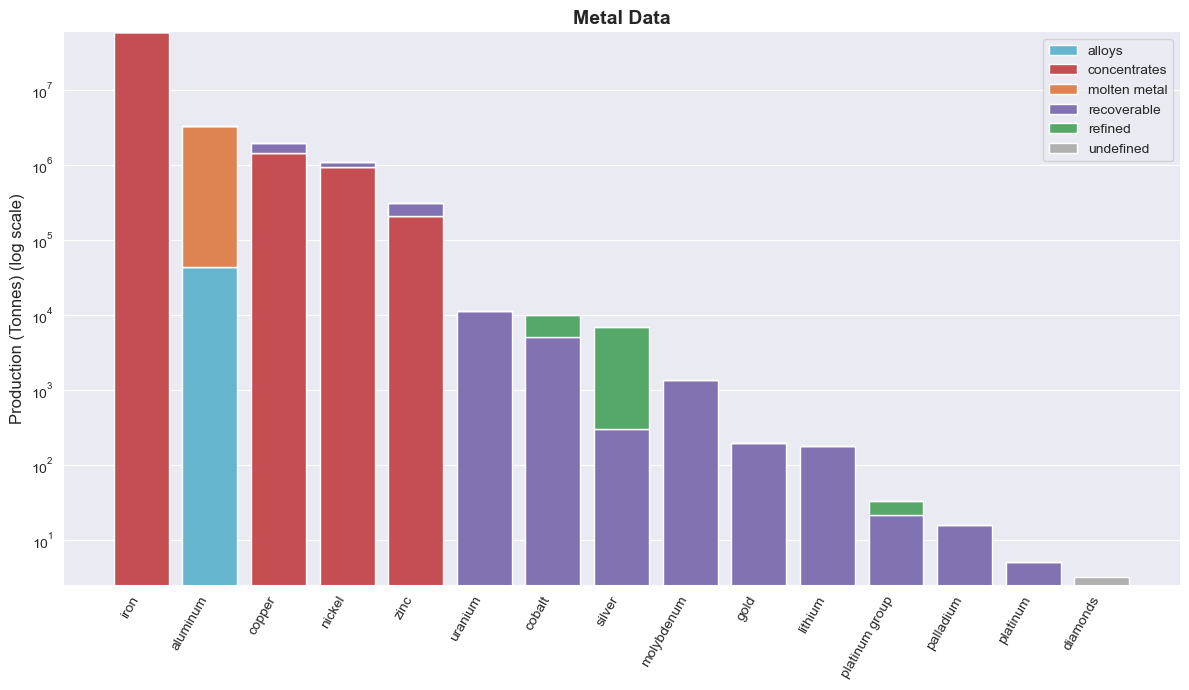

In [50]:
plot_stacked_metal_data(df_nrcan_prod_2023, title="Metal Data", save_prefix='results/technical_validation/nrcan_metal_data_2023')

# Data from Jasansky et al (2023)

In [51]:
jasansky_min = pd.read_csv('data/Sources/Jasansky_2023/canada_minerals.csv')
jasansky_cap = pd.read_csv('data/Sources/Jasansky_2023/canada_capacity.csv')
jasansky_com = pd.read_csv('data/Sources/Jasansky_2023/canada_commodities.csv')

In [52]:
jasansky_min

,facility_name,facility_type,primary_commodity,commodities_products,id,facility_id,year,type,material,value_tonnes,overall_grade_ppm,amount_sold_tonnes,mine_processing,reporting_period,source_id,comment,sources,source_urls
0,777,Mine,Copper,"Copper, Zinc, Gold, Silver",1,COM00001.00,2013,Ore mined,O.bulk,1625532,NaN,NaN,NaN,NaN,det_1729,NaN,Hudbay Minerals Inc. (2015) Management's Discu...,https://s23.q4cdn.com/405985100/files/doc_fina...
1,777,Mine,Copper,"Copper, Zinc, Gold, Silver",2,COM00001.00,2013,Ore processed,O.bulk,1625532,NaN,NaN,NaN,NaN,det_1729,NaN,Hudbay Minerals Inc. (2015) Management's Discu...,https://s23.q4cdn.com/405985100/files/doc_fina...
2,777,Mine,Copper,"Copper, Zinc, Gold, Silver",3,COM00001.00,2014,Ore mined,O.bulk,1452933,NaN,NaN,NaN,NaN,det_1729,NaN,Hudbay Minerals Inc. (2015) Management's Discu...,https://s23.q4cdn.com/405985100/files/doc_fina...
3,777,Mine,Copper,"Copper, Zinc, Gold, Silver",4,COM00001.00,2014,Ore processed,O.bulk,1452933,NaN,NaN,NaN,NaN,det_1729,NaN,Hudbay Minerals Inc. (2015) Management's Discu...,https://s23.q4cdn.com/405985100/files/doc_fina...
4,777,Mine,Copper,"Copper, Zinc, Gold, Silver",5,COM00001.00,2015,Ore mined,O.bulk,1235053,NaN,NaN,NaN,NaN,det_1730,NaN,Hudbay Minerals Inc. (2016) Management's Discu...,https://s23.q4cdn.com/405985100/files/doc_fina...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,Wabush,Mine,Iron,"Iron, Iron ore pellets",11632,COM01345.00,2006,Concentrate,Con.Fe,4165793,NaN,NaN,NaN,NaN,det_1926,NaN,Cleveland-Cliffs Inc. (2007) 10-K Annual Repor...,http://d1lge852tjjqow.cloudfront.net/CIK-00007...
933,Wabush,Mine,Iron,"Iron, Iron ore pellets",11633,COM01345.00,2007,Concentrate,Con.Fe,4673816,NaN,NaN,NaN,NaN,det_1236,NaN,Cleveland-Cliffs Inc. (2009) 10-K Annual Repor...,http://d1lge852tjjqow.cloudfront.net/CIK-00007...
934,Wabush,Mine,Iron,"Iron, Iron ore pellets",11634,COM01345.00,2008,Concentrate,Con.Fe,4267397,NaN,NaN,NaN,NaN,det_1236,NaN,Cleveland-Cliffs Inc. (2009) 10-K Annual Repor...,http://d1lge852tjjqow.cloudfront.net/CIK-00007...
935,Wabush,Mine,Iron,"Iron, Iron ore pellets",11635,COM01345.00,2013,Concentrate,Con.Fe,2844932,NaN,NaN,NaN,NaN,det_1237,NaN,Cleveland-Cliffs Inc. (2014) 10-K Annual Repor...,http://d1lge852tjjqow.cloudfront.net/CIK-00007...


In [53]:
jasansky_min['facility_name'].unique()

array(['777', 'Birchtree', 'Bloom Lake', 'Bracemac-McLeod', 'Brunswick',
       'Canadian Malartic', 'Coleman', 'Copper Cliff North',
       'Copper Cliff South', 'Creighton', 'Duck Pond', 'Ekati',
       'Eleonore', 'Ellen', 'Eskay Creek', 'Garson', 'Gertrude', 'Goldex',
       'Hemlo', 'Highland Valley Copper', 'Holt-McDermott',
       'Iron Ore Company of Canada Labrador City', 'Lalor', 'Lapa',
       'LaRonde Complex', 'Meadowbank Complex', 'Meliadine', 'Minto',
       'Mont Wright', 'Montcalm', 'Musselwhite', 'Ovoid', 'Porcupine',
       'Red Lake', 'Reed', 'Seabee', 'Selbaie', 'Silvertip', 'Stobie',
       'Sudbury Integrated Nickel Operations', 'Thompson',
       'Timmins West & Bell Creek', 'Totten', 'Touquoy', 'Wabush'],
      dtype=object)

In [54]:
jasansky_com['facility_name'].unique()

array(['777', 'Birchtree', 'Bloom Lake', 'Bracemac-McLeod', 'Brunswick',
       'Canadian Malartic', 'Coleman', 'Copper Cliff North',
       'Copper Cliff South', 'Creighton', 'Diavik', 'Duck Pond', 'Ekati',
       'Eleonore', 'Ellen', 'Eskay Creek', 'Garson', 'Gertrude', 'Goldex',
       'Hemlo', 'Highland Valley Copper', 'Holt-McDermott', 'Kidd',
       'Lalor', 'Lapa', 'LaRonde Complex', 'Meadowbank Complex',
       'Meliadine', 'Minto', 'Mont Wright', 'Montcalm', 'Morrison',
       'Musselwhite', 'Ovoid', 'Porcupine', 'Red Lake', 'Reed', 'Seabee',
       'Selbaie', 'Silvertip', 'Stobie',
       'Sudbury Integrated Nickel Operations', 'Thompson',
       'Timmins West & Bell Creek', 'Totten', 'Touquoy'], dtype=object)

# Production data from MetalliCan

In [55]:
df_metallican_prod = pd.read_excel(r'data/Tables/extracted_data.xlsx', sheet_name='Production') # Filter for the year 2023

In [56]:
df_metallican_prod = df_metallican_prod[
    (df_metallican_prod["data_type"] == "Production") &
    (df_metallican_prod["geography"] == "Canada")
].copy()

In [57]:
# Temporarily replace year 2022 and 2024 with 2023 for consistency
df_metallican_prod["year"] = df_metallican_prod["year"].replace({2021: 2023, 2022: 2023, 2024: 2023})

In [58]:
df_metallican_prod['material_type'].unique()

array(['Ore processed', 'Intermediate metal', 'Concentrate',
       'Refinery production', 'Ore mined', 'Mining production', 'Flat',
       'Long/wire rod, bars, slabs', 'Iron ore', 'Concentrate & pellets',
       'Gold production', 'Waste mined', 'Concentrate produced',
       'Waste rock mined', 'Intermediate metal ', 'Carats recovered',
       'Ore milled', 'Material mined', 'EAF production',
       'Contained metal in concentrate', 'Metal contained in concentrate',
       'Finished production', 'Ore delivered', 'Gold ounces sold',
       'Total contained metal in concentrate and doré produced',
       'Tonnes mined', '?', 'Ore mined|OP ore', 'Ore mined|OP waste',
       'Ore mined|Underground', 'Smelter production', 'Diamond recovered',
       'Not specified', 'Smelter grade alumina', 'Bullion', 'Refined',
       'Numismatic', 'Concentrate (spodumene)', 'Gold',
       'Refined production'], dtype=object)

In [59]:
df_metallican_prod["unit_normalized"] = df_metallican_prod["unit"].str.strip().str.lower()

In [60]:
df_metallican_prod['unit_normalized'].unique()

array(['t', 'oz', 'koz', 'mt', 'kt', 'mcts', 'mdmt', 'mwmt', 'mlbs',
       'dmt', 'wmt', 'kct', 'klbs', 'moz'], dtype=object)

In [61]:
# Define reference point mapping based on Simoni et al.
reference_point_map = {
    1: "Ore mined",
    2: "Ore processed",
    3: "Concentrate produced",
    4: "Intermediate metal produced",
    5: "Refined metal"
}

# Apply the mapping
df_metallican_prod["reference_point_label"] = df_metallican_prod["reference_point"].map(reference_point_map)

In [62]:
df_metallican_prod

,year,level,geography,reported_company_nrcan,name,main_id,facility_group_id,company_id,facility_type,mining_processing_type,...,commodity,reference_point,material_type,data_type,unit,value,comment,source,unit_normalized,reference_point_label
0,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a43,-,NaN,mining,"Underground, concentrator",...,Ore,2,Ore processed,Production,t,1.959493e+07,NaN,2023-Sustainability-Performance_data,t,Ore processed
1,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a44,-,NaN,mining,"Underground, concentrator",...,Gold,4,Intermediate metal,Production,oz,6.846400e+05,"""Production reflects Agnico Eagle's 50% intere...",2023-Sustainability-Performance_data,oz,Intermediate metal produced
2,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a45,-,NaN,mining,"Underground, concentrator",...,Silver,4,Intermediate metal,Production,koz,3.100000e+02,"""Production reflects Agnico Eagle's 50% intere...",2023-Sustainability-Performance_data,koz,Intermediate metal produced
3,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Detour Lake,QC-MAIN-e7e6a960,-,NaN,mining,"Open-pit, concentrator",...,Gold,2,Ore processed,Production,t,2.543485e+07,NaN,2023-Sustainability-Performance_data,t,Ore processed
4,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Detour Lake,QC-MAIN-e7e6a963,-,NaN,mining,"Open-pit, concentrator",...,Gold,4,Intermediate metal,Production,oz,6.774460e+05,Like intermediate metal,2023-Sustainability-Performance_data,oz,Intermediate metal produced
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Eagle River,QC-MAIN-9de9bb0d,-,NaN,mining,"Underground, concentrator",...,Gold,2,Ore milled,Production,t,2.226270e+05,NaN,2024-MDA-FINAL,t,Ore processed
337,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Eagle River,QC-MAIN-9de9bb0d,-,NaN,mining,"Underground, concentrator",...,Gold,2,Ore processed,Production,t,2.700000e+00,NaN,2023-ESG-Data-Tables,t,Ore processed
340,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Kiena,ON-MAIN-c5fefb01,-,NaN,mining,"Open-pit, concentrator",...,Gold,4,Intermediate metal,Production,Oz,3.553700e+04,NaN,2024-MDA-FINAL,oz,Intermediate metal produced
341,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Kiena,ON-MAIN-c5fefb01,-,NaN,mining,"Open-pit, concentrator",...,Gold,2,Ore milled,Production,t,1.911480e+05,NaN,2024-MDA-FINAL,t,Ore processed


In [63]:
unit_conversion = {
    "t": 1,
    "kt": 1_000,
    "mt": 1_000_000,
    "kg": 1e-3,
    "g": 1e-6,
    "oz": 0.0000311035,
    "koz": 0.0311035,
    "moz": 31.1035,
    "oz au": 0.0000311035,
    "oz au eq": 0.0000311035,
    "mlbs": 453.592 / 1_000 * 1_000_000,
    "klbs": 453.592 / 1_000 * 1_000,
    "million lbs": 453.592 / 1_000 * 1_000_000,
    "lb": 0.000453592,
    "wmt": 1,
    "dmt": 1,
    "mwmt": 1_000_000,
    "mdmt": 1_000_000,
    "kct": 2e-7,
    "mcts": 2e-4,
}

df_metallican_prod["conversion_factor"] = df_metallican_prod["unit_normalized"].map(unit_conversion)
df_metallican_prod["value_tonnes"] = df_metallican_prod["value"] * df_metallican_prod["conversion_factor"]
df_metallican_prod

,year,level,geography,reported_company_nrcan,name,main_id,facility_group_id,company_id,facility_type,mining_processing_type,...,material_type,data_type,unit,value,comment,source,unit_normalized,reference_point_label,conversion_factor,value_tonnes
0,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a43,-,NaN,mining,"Underground, concentrator",...,Ore processed,Production,t,1.959493e+07,NaN,2023-Sustainability-Performance_data,t,Ore processed,1.000000,1.959493e+07
1,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a44,-,NaN,mining,"Underground, concentrator",...,Intermediate metal,Production,oz,6.846400e+05,"""Production reflects Agnico Eagle's 50% intere...",2023-Sustainability-Performance_data,oz,Intermediate metal produced,0.000031,2.129470e+01
2,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a45,-,NaN,mining,"Underground, concentrator",...,Intermediate metal,Production,koz,3.100000e+02,"""Production reflects Agnico Eagle's 50% intere...",2023-Sustainability-Performance_data,koz,Intermediate metal produced,0.031103,9.642085e+00
3,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Detour Lake,QC-MAIN-e7e6a960,-,NaN,mining,"Open-pit, concentrator",...,Ore processed,Production,t,2.543485e+07,NaN,2023-Sustainability-Performance_data,t,Ore processed,1.000000,2.543485e+07
4,2023,Site-specific,Canada,Agnico Eagle Mines Limited,Detour Lake,QC-MAIN-e7e6a963,-,NaN,mining,"Open-pit, concentrator",...,Intermediate metal,Production,oz,6.774460e+05,Like intermediate metal,2023-Sustainability-Performance_data,oz,Intermediate metal produced,0.000031,2.107094e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Eagle River,QC-MAIN-9de9bb0d,-,NaN,mining,"Underground, concentrator",...,Ore milled,Production,t,2.226270e+05,NaN,2024-MDA-FINAL,t,Ore processed,1.000000,2.226270e+05
337,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Eagle River,QC-MAIN-9de9bb0d,-,NaN,mining,"Underground, concentrator",...,Ore processed,Production,t,2.700000e+00,NaN,2023-ESG-Data-Tables,t,Ore processed,1.000000,2.700000e+00
340,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Kiena,ON-MAIN-c5fefb01,-,NaN,mining,"Open-pit, concentrator",...,Intermediate metal,Production,Oz,3.553700e+04,NaN,2024-MDA-FINAL,oz,Intermediate metal produced,0.000031,1.105325e+00
341,2023,Site-specific,Canada,Wesdome Gold Mines Ltd,Kiena,ON-MAIN-c5fefb01,-,NaN,mining,"Open-pit, concentrator",...,Ore milled,Production,t,1.911480e+05,NaN,2024-MDA-FINAL,t,Ore processed,1.000000,1.911480e+05


In [64]:
missing_units = df_metallican_prod[df_metallican_prod["conversion_factor"].isna()]["unit_normalized"].unique()
print("⚠️ Units not mapped:", missing_units)


⚠️ Units not mapped: []


In [65]:
# Identify rows with missing conversion or reference point
failed_conversion = df_metallican_prod[
    df_metallican_prod["conversion_factor"].isna() | df_metallican_prod["reference_point_label"].isna()
]
failed_conversion

,year,level,geography,reported_company_nrcan,name,main_id,facility_group_id,company_id,facility_type,mining_processing_type,...,material_type,data_type,unit,value,comment,source,unit_normalized,reference_point_label,conversion_factor,value_tonnes


In [66]:
# Drop rows where conversion is not possible
#df_metallican_prod = df_metallican_prod.dropna(subset=["conversion_factor", "reference_point_label"])
#df_metallican_prod

In [67]:
summary_metallican_2023 = df_metallican_prod.groupby(["commodity", "reference_point_label"])["value_tonnes"].sum().reset_index()
summary_metallican_2023

,commodity,reference_point_label,value_tonnes
0,Aluminum,Intermediate metal produced,3.531969e+06
1,Cobalt,Refined metal,3.368000e+03
2,Concentrate,Concentrate produced,1.422850e+05
3,Copper,Concentrate produced,2.842826e+07
4,Copper,Intermediate metal produced,9.459434e+07
5,Diamonds,Concentrate produced,2.254752e-03
6,Diamonds,Ore mined,2.120000e+07
7,Diamonds,Ore processed,4.200000e+06
8,Ferroniobium,Intermediate metal produced,1.170000e+04
9,GEOs,Intermediate metal produced,3.172557e-04


In [68]:
summary_metallican_2023.to_csv(r'results/technical_validation/summary_metallican_2023.csv', index=False)

# Compare NRCan and MetalliCan data

In [69]:
df_db = summary_metallican_2023[["commodity", "reference_point_label", "value_tonnes"]].copy()
df_db["source"] = "MetalliCan"

df_nrcan = df_nrcan_prod_2023[["Commodity", "reference_point_label", "value_tonnes"]].copy()
df_nrcan.rename(columns={"Commodity": "commodity"}, inplace=True)
df_nrcan["source"] = "NRCan"

# Standardize casing in both datasets
df_db["commodity"] = df_db["commodity"].str.strip().str.lower()
df_db["reference_point_label"] = df_db["reference_point_label"].str.strip().str.lower()

df_nrcan["commodity"] = df_nrcan["commodity"].str.strip().str.lower()
df_nrcan["reference_point_label"] = df_nrcan["reference_point_label"].str.strip().str.lower()

# Concatenate both for comparison
df_comparison = pd.concat([df_db, df_nrcan], ignore_index=True)

# Pivot the data to make source columns side-by-side
df_comparison_pivot = df_comparison.pivot_table(
    index=["commodity", "reference_point_label"],
    columns="source",
    values="value_tonnes",
    aggfunc="sum"
).reset_index()

df_comparison_pivot

source,commodity,reference_point_label,MetalliCan,NRCan
0,aluminum,intermediate metal produced,3.531969e+06,3.301844e+06
1,cobalt,intermediate metal produced,NaN,5.099000e+03
2,cobalt,refined metal,3.368000e+03,4.923174e+03
3,concentrate,concentrate produced,1.422850e+05,NaN
4,copper,concentrate produced,2.842826e+07,1.472936e+06
5,copper,intermediate metal produced,9.459434e+07,5.082500e+05
6,diamonds,concentrate produced,2.254752e-03,NaN
7,diamonds,nan,NaN,3.232138e+00
8,diamonds,ore mined,2.120000e+07,NaN
9,diamonds,ore processed,4.200000e+06,NaN


In [70]:
df_comparison_pivot.to_csv(r'results/technical_validation/df_comparison.csv', index=False)

# Heatmap of satellite data 

In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def heatmap(excel_path, base_save_path=None, dpi=600, max_cells_annotate=300):
    """
    Generate one heatmap per reporting level using data from extracted_data.xlsx.

    Parameters:
    - excel_path (str): Path to extracted_data.xlsx
    - base_save_path (str or None): Prefix for saved PNG files (e.g., "heatmap"). Appends level as suffix.
    - dpi (int): Image resolution
    - max_cells_annotate (int): Max annotated cells to prevent overcrowding
    """

    # Load all necessary sheets
    env_df = pd.read_excel(excel_path, sheet_name="Env")
    reserves_df = pd.read_excel(excel_path, sheet_name="Reserves")
    production_df = pd.read_excel(excel_path, sheet_name="Production")
    energy_df = pd.read_excel(excel_path, sheet_name="Energy")

    # ENVIRONMENTAL DATA
    env_df_clean = env_df.assign(
        type_group="environmental",
        type=env_df["type"].str.strip(),
        reporting_level=env_df["reporting_level"].str.strip(),
        commodities=env_df["commodity"].str.strip()
    )[["commodities", "type", "type_group", "reporting_level"]]

    # RESERVES DATA
    reserves_df_clean = reserves_df.assign(
        type_group="reserves",
        type=reserves_df["reserves_resources"].str.strip(),
        reporting_level=reserves_df["reporting_level"].str.strip(),
        commodities=reserves_df["commodity"].str.strip()
    )[["commodities", "type", "type_group", "reporting_level"]]

    # PRODUCTION DATA
    production_df_clean = production_df.assign(
        type_group="production",
        type=production_df["data_type"].str.strip(),
        reporting_level=production_df["level"].str.strip(),
        commodities=production_df["commodity"].str.strip()
    )[["commodities", "type", "type_group", "reporting_level"]]

    # ENERGY DATA
    energy_df_clean = energy_df.assign(
        type_group="energy",
        type="energy_flow",
        reporting_level=energy_df["reporting_level"].str.strip(),
        commodities=energy_df["commodity"].str.strip()
    )[["commodities", "type", "type_group", "reporting_level"]]

    # COMBINE ALL
    combined_df = pd.concat([
        env_df_clean,
        reserves_df_clean,
        production_df_clean,
        energy_df_clean
    ], ignore_index=True)

    # GROUP AND PLOT
    grouped = combined_df.groupby(['reporting_level', 'commodities', 'type']).size().reset_index(name='count')
    reporting_levels = grouped['reporting_level'].dropna().unique()

    for level in reporting_levels:
        data = grouped[grouped['reporting_level'] == level]
        pivot = data.pivot(index='commodities', columns='type', values='count').fillna(0)

        n_rows, n_cols = pivot.shape
        fig_width = min(0.5 * n_cols + 4, 40)
        fig_height = min(0.5 * n_rows + 4, 40)
        annotate = (n_rows * n_cols) <= max_cells_annotate

        plt.figure(figsize=(fig_width, fig_height), dpi=dpi)
        sns.heatmap(
            pivot,
            annot=annotate,
            fmt=".0f",
            cmap="crest",
            linewidths=0.5,
            annot_kws={"size": 6} if annotate else None
        )
        plt.title(f"Data Coverage for Reporting Level: {level}", fontsize=14)
        plt.xlabel("", fontsize=12)
        plt.ylabel("Commodity", fontsize=12)
        plt.xticks(rotation=90, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()

        if base_save_path:
            safe_level = level.replace(" ", "_").replace("/", "_")
            save_path = f"{base_save_path}_{safe_level}.pdf"
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()
        else:
            plt.show()

In [20]:
heatmap(
    excel_path="data/Tables/extracted_data.xlsx",
    base_save_path="results/data_coverage/heatmaps.pdf"
)


# Sankey

In [ ]:
import os
import pandas as pd
import plotly.graph_objects as go

def create_sankey(
    df,
    save_path
):
    """
    Creates a Sankey diagram:
    - Mining/Manufacturing: Facility Type → Company Name → Commodity
    - Project: Facility Type → Commodity

    Parameters
    ----------
    df : pd.DataFrame
        Must contain 'facility_type', 'company_name_folder', 'commodities_nrcan'
    save_path : str
        Path WITHOUT extension (e.g., 'results/sankey/facility_company_commodity')
    """
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    # 1) Basic cleaning
    df_viz = df[['facility_type', 'company_name_folder', 'commodities_nrcan']].dropna(subset=['facility_type']).copy()
    df_viz['commodities_nrcan'] = df_viz['commodities_nrcan'].fillna('Unknown')
    df_viz = df_viz.assign(commodities_nrcan=df_viz['commodities_nrcan'].str.split(', ')).explode('commodities_nrcan')

    # 2) Define nodes
    facility_types = df_viz['facility_type'].unique().tolist()
    companies = df_viz['company_name_folder'].dropna().unique().tolist()
    commodities = df_viz['commodities_nrcan'].unique().tolist()

    node_labels = facility_types + companies + commodities
    node_colors = (
        ["#66c2a5"] * len(facility_types) +
        ["#fc8d62"] * len(companies) +
        ["#8da0cb"] * len(commodities)
    )
    node_indices = {label: idx for idx, label in enumerate(node_labels)}

    # 3) Build links
    sources = []
    targets = []
    values = []

    # Separate data
    df_mine_manuf = df_viz[df_viz['facility_type'].isin(['mining', 'manufacturing'])]
    df_project = df_viz[df_viz['facility_type'] == 'project']

    # a) mining/manufacturing: facility_type → company
    links_fc = df_mine_manuf.groupby(['facility_type', 'company_name_folder']).size().reset_index(name='count')
    for _, row in links_fc.iterrows():
        sources.append(node_indices[row['facility_type']])
        targets.append(node_indices[row['company_name_folder']])
        values.append(row['count'])

    # b) company → commodity
    links_cc = df_mine_manuf.groupby(['company_name_folder', 'commodities_nrcan']).size().reset_index(name='count')
    for _, row in links_cc.iterrows():
        sources.append(node_indices[row['company_name_folder']])
        targets.append(node_indices[row['commodities_nrcan']])
        values.append(row['count'])

    # c) project: facility_type → commodity
    links_pc = df_project.groupby(['facility_type', 'commodities_nrcan']).size().reset_index(name='count')
    for _, row in links_pc.iterrows():
        sources.append(node_indices[row['facility_type']])
        targets.append(node_indices[row['commodities_nrcan']])
        values.append(row['count'])

    # 4) Build figure
    fig = go.Figure(go.Sankey(
        arrangement="snap",
        node=dict(
            pad=15, thickness=20, line=dict(color="black", width=1),
            label=node_labels, color=node_colors,
        ),
        link=dict(source=sources, target=targets, value=values)
    ))

    fig.update_layout(
        font_family="Arial", font_color='black', font_size=12,
        width=1400, height=800,
        paper_bgcolor="white", plot_bgcolor="white"
    )

    # 5) Save outputs
    fig.write_html(f"{save_path}.html")
    try:
        fig.write_image(f"{save_path}.pdf", format="pdf", width=1400, height=800, scale=2)
    except ValueError:
        print("Warning: Kaleido not installed, PDF export skipped.")

    return fig